In [119]:
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import Flatten, concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.utils import plot_model

In [120]:
from tensorflow.keras.layers import BatchNormalization

In [121]:
from sklearn.model_selection import train_test_split

In [122]:
from tensorflow.keras.optimizers import SGD, Adam

In [231]:
import tensorflow as tf

In [123]:
def import_hf5(data_path, data_name, get_name):
    hf = h5py.File(os.path.join(data_path, data_name), mode="r")
    data = hf.get(get_name)
    stack = np.array(data)
    hf.close()
    return stack

In [124]:
#code from https://github.com/tgrippa/Partimap/blob/cd72ecd2f3e32794eb3e0ee70399de1811b5399e/Notebooks/Data_preprocessing.ipynb
def normalise_01(image_data):
    stack = image_data
    image_data -= np.min(stack, axis=0)
    image_data /= (np.max(stack, axis=0) - np.min(stack, axis=0))
    return image_data

In [125]:
def standardise(image_data):
    image_data -= np.mean(image_data, axis=0, dtype=np.float32)
    image_data /= np.std(image_data, axis=0, dtype=np.float32)
    return image_data

In [126]:
def circle(train_lulc,test_lulc,title) :
    train_slum = (train_lulc==1).sum()
    train_noslum = (train_lulc==0).sum()
    test_slum = (test_lulc==1).sum()
    test_noslum = (test_lulc==0).sum()
    
    RESTRAIN = [train_slum,train_noslum]
    RESTEST = [test_slum,test_noslum]
    RESLABEL1 = ['Training slums', 'Training no slums' ]
    RESLABEL2 = ['Test slums', 'Test no slums']
    
    
    fig, (ax1, ax2) = plt.subplots(1, 2)
    ax1.pie(RESTRAIN, labels=RESLABEL1, autopct='%1.1f%%',
        shadow=True, startangle=90)
    ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
    ax2.pie(RESTEST, labels=RESLABEL2, autopct='%1.1f%%',
        shadow=True, startangle=90)
    ax2.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
    
    
    plt.title(title)
    
    plt.show()

In [127]:
from osgeo import gdal
import numpy as np

#code inspired from https://github.com/tgrippa/Partimap/blob/cd72ecd2f3e32794eb3e0ee70399de1811b5399e/Notebooks/Data_preprocessing.ipynb
def stackage(list_raster):
    stack = []
    for patch in list_raster :
        pat = gdal.Open(patch)#.decode('ascii')
        data_rast = pat.ReadAsArray().astype(np.float32)
        data_rast = np.transpose(data_rast,(1,2,0))
        stack.append(data_rast)

    stack= np.array(stack)
    
    return stack


In [251]:
def assimilation(patch_id_train, patch_id_test, path_raster):
    train_path = [None] * 10
    test_path = [None] * 10

    patch_id_train_re = patch_id_train.reshape(1,patch_id_train.size)
    patch_id_train_list = patch_id_train_re.tolist()[0]
    patch_id_test_re = patch_id_test.reshape(1,patch_id_test.size)
    patch_id_test_list = patch_id_test_re.tolist()[0]
    
    train_path = [None] * len(patch_id_train)
    test_path = [None] * len(patch_id_test)
    
    for path in path_raster : #récupération des id des images
        image = path.split('/')[-1]
        image_id = int(image.split('_')[-2])
        if image_id in patch_id_train_list :
            index = patch_id_train_list.index(image_id)
            train_path[index] = path
        elif image_id in patch_id_test_list :
            index = patch_id_test_list.index(image_id)
            test_path[index] = path

    #stack = stackage(train_path)

    stack_train = stackage(train_path)
    #stack = stackage(test_path)
    stack_test = stackage(test_path)

    
    plt.rcParams["figure.facecolor"] = 'w'
    plt.figure(figsize=(15, 15))
    for i in range(3):
        rd_img = np.random.randint(1,500)
        ax = plt.subplot(1, 3, i + 1)
        plt.imshow(Norma_Xpercentile(stack_test[rd_img,:,:,:]))
        plt.axis("off")
        plt.title("Random indx: %s\nID: %s\nlulc: %0.3f" %(rd_img,patch_id_test[rd_img],patch_lulc_test[rd_img]))
        print(stack_test[rd_img,0,0,:])
        print(test_path[rd_img])
        print(patch_id_test[rd_img])
    #plt.subplots_adjust(hspace=0.001)
    plt.tight_layout() 
    
    stack_train = normalise_01(stack_train)
    stack_test = normalise_01(stack_test)


    return stack_train, stack_test

In [129]:
def make_csv(predict, patch_id_raster, name):
    import csv

    predict = predict.reshape(1,predict.size).tolist()[0]

    header = ['prob_slum','id']
    cont = []
    cont.append(header)
    for x,y in zip(predict,patch_id_raster):
        current_row = [x,y]
        cont.append(current_row)

    cont

    with open(str(name)+'.csv','w') as file :
        write = csv.writer(file)
        write.writerows(cont)

In [130]:
def reshape(list_input):
    L = np.array(list_input)
    L = L.reshape(L.size,-1)
    
    return L

In [146]:
import h5py
import os, sys

In [147]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

In [148]:
# Add local module to the path
src = os.path.abspath('SRC/')
if src not in sys.path:
    sys.path.append(src)


In [149]:
# Import functions for processing time information
from processing_time import start_processing, print_processing_time
# Import function that checks and creates folder
from mkdir import check_create_dir
# Import functions for plots
from plots import plot_loss, plot_pred_test, plot_pred_train, plot_loss_multirun
# Import functions for metrics to monitoring accuracy
from metrics import coeff_determination
# Import functions for display
from display import Norma_Xpercentile
# Import functions for exportation of results
from export_results import save_predictions, write_run_metrics_file
# Import LRFinder function
from LRFinder import LRFinder

## Importing and pre-processing data

In [132]:
from chunckage import chunckage

S1_patch_path, S1_patch_id, S1_patch_lulc = chunckage("Images/big_raster/","ALLS1",".tif",'Images/big_sample/','sample.gpkg','tr_ALLS1',1)
S2_patch_path, S2_patch_id, S2_patch_lulc = chunckage("Images/big_raster/","RGBNIR",".tif",'Images/big_sample/','sample.gpkg','tr_RBGNIR',1)

(238890.0, 288990.0, 9846480.0, 9871580.0)
(238890.0, 288990.0, 9846480.0, 9871580.0)


In [133]:
S1_grid_path, S1_grid_id = chunckage("Images/big_raster/","ALLS1",".tif",'Images/big_grid/','grid.gpkg','g_ALLS1',0)
S2_grid_path, S2_grid_id = chunckage("Images/big_raster/","RGBNIR",".tif",'Images/big_grid/','grid.gpkg','g_RBGNIR',0)


(238890.0, 289090.0, 9846380.0, 9871680.0)
(238890.0, 289090.0, 9846380.0, 9871680.0)


In [138]:
data_path = 'Images/big_raster/tr_ALLS1_patch/'
with h5py.File(os.path.join(data_path,"tr_Ymodel.hdf5"), mode="a") as f:
    f["id_sar"] = S1_patch_id               
    f["id_rgb"] = S2_patch_id                 
    f["lulc_sar"] = S1_patch_lulc          
    f["lulc_rgb"] = S2_patch_lulc       
    f["patch_sar_path"] = S1_patch_path  
    f["patch_rgb_path"] = S1_patch_path

print("Data exported in %s"%(data_path))

Data exported in Images/big_raster/tr_ALLS1_patch/


In [139]:
data_path = 'Images/big_raster/g_ALLS1_patch/'
with h5py.File(os.path.join(data_path,"g_Ymodel.hdf5"), mode="a") as f:
    f["id_sar"] = S1_grid_id               
    f["id_rgb"] = S2_grid_id                       
    f["patch_sar_path"] = S1_grid_path  
    f["patch_rgb_path"] = S1_grid_path

print("Data exported in %s"%(data_path))

Data exported in Images/big_raster/g_ALLS1_patch/


In [140]:
stack = stackage(S1_grid_path)
S1_stack_grid = normalise_01(stack)

stack = stackage(S2_grid_path)
S2_stack_grid = normalise_01(stack)

In [196]:
patch_id_train, patch_id_test, patch_lulc_train, patch_lulc_test = train_test_split(S1_patch_id,S1_patch_lulc, test_size=0.2, random_state=100)
patch_id_train = reshape(patch_id_train)
patch_id_test = reshape(patch_id_test)
patch_lulc_train = reshape(patch_lulc_train)
patch_lulc_test = reshape(patch_lulc_test)   

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[ 414.  435.  245. 2164.]
Images/big_raster/tr_RBGNIR_patch/tr_RBGNIR_17612_0.tif
[17612]
[1228.  721.  519. 2266.]
Images/big_raster/tr_RBGNIR_patch/tr_RBGNIR_39592_0.tif
[39592]
[1182.  913.  702. 2034.]
Images/big_raster/tr_RBGNIR_patch/tr_RBGNIR_87990_0.tif
[87990]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[ 602.  549.  292. 2530.]
Images/big_raster/tr_RBGNIR_patch/tr_RBGNIR_13066_0.tif
[13066]
[1770. 1044.  671. 2344.]
Images/big_raster/tr_RBGNIR_patch/tr_RBGNIR_8536_0.tif
[8536]
[ 590.  642.  345. 3064.]
Images/big_raster/tr_RBGNIR_patch/tr_RBGNIR_26051_0.tif
[26051]


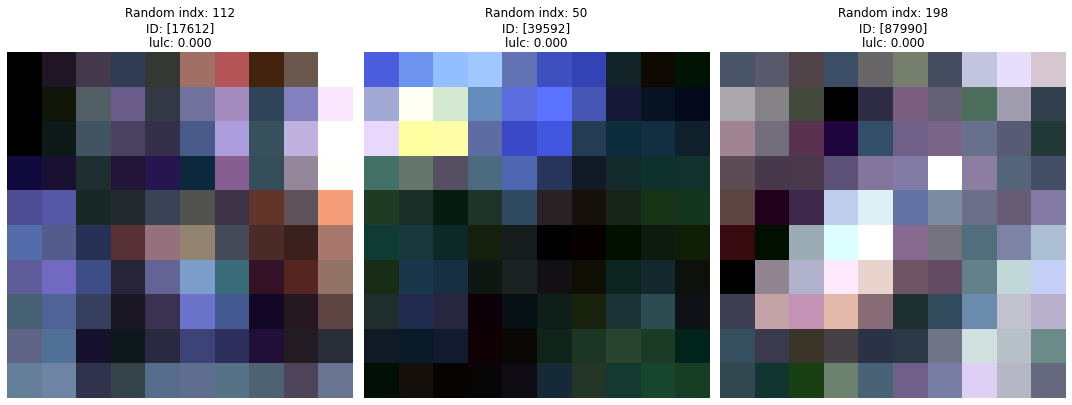

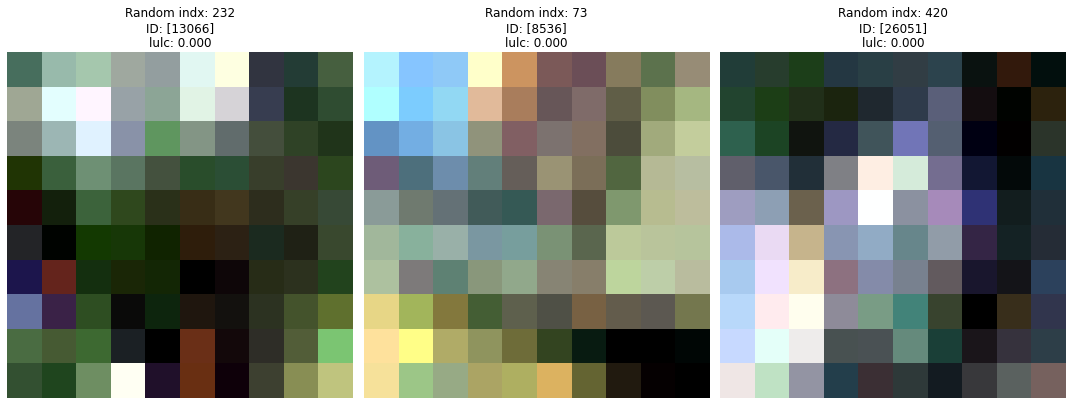

In [252]:
stack_train = assimilation(patch_id_train, patch_id_test, S2_patch_path)[0]
stack_test = assimilation(patch_id_train, patch_id_test, S2_patch_path)[1]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[  0.4446093 -16.545603  -23.188389 ]
Images/big_raster/tr_ALLS1_patch/tr_ALLS1_119508_0.tif
[119508]
[  0.41532633 -12.245742   -20.029324  ]
Images/big_raster/tr_ALLS1_patch/tr_ALLS1_113229_0.tif
[113229]
[  0.5212654  -3.6381402 -12.183312 ]
Images/big_raster/tr_ALLS1_patch/tr_ALLS1_60550_0.tif
[60550]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[  0.29281473 -14.469546   -22.429855  ]
Images/big_raster/tr_ALLS1_patch/tr_ALLS1_95205_0.tif
[95205]
[  0.30426973  -8.32239    -13.098521  ]
Images/big_raster/tr_ALLS1_patch/tr_ALLS1_10211_0.tif
[10211]
[  0.43534914 -10.564268   -15.613634  ]
Images/big_raster/tr_ALLS1_patch/tr_ALLS1_41402_0.tif
[41402]


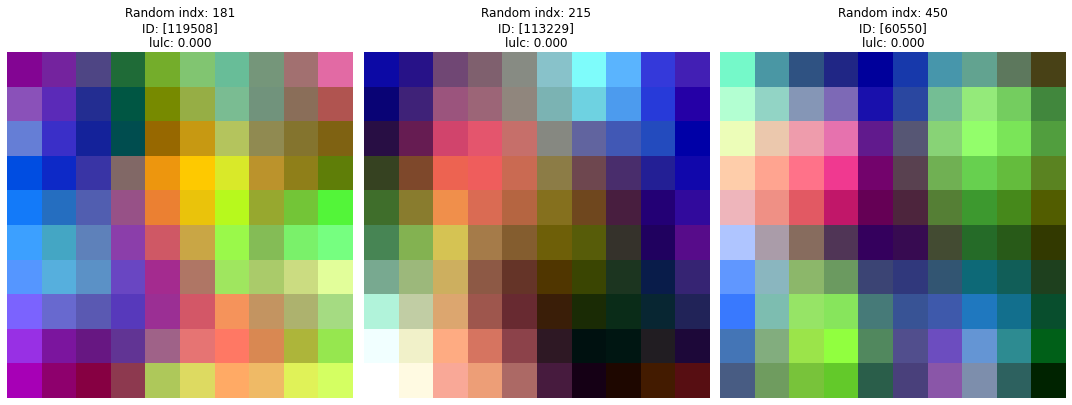

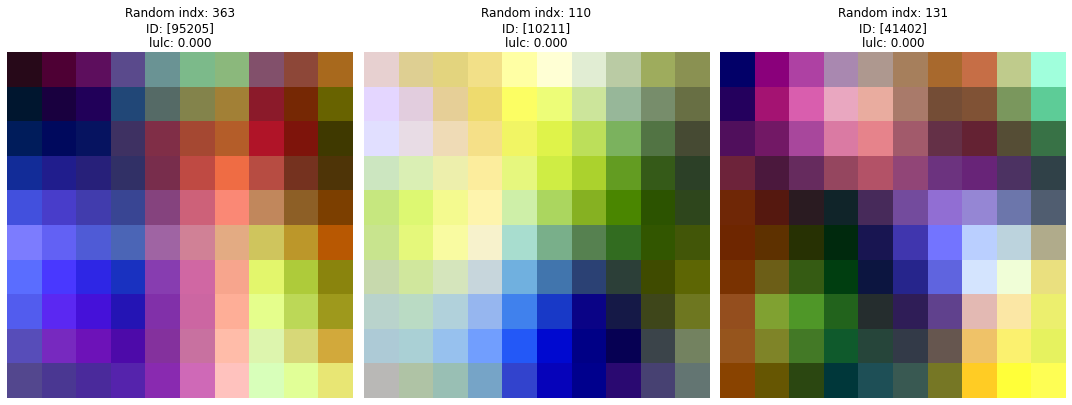

In [253]:
stack_sar_train = assimilation(patch_id_train, patch_id_test, S1_patch_path)[0]
stack_sar_test = assimilation(patch_id_train, patch_id_test, S1_patch_path)[1]

## Model definition

In [243]:
def ymodel(left_input_shape,right_input_shape,batch_size,kernel_size,dropout,n_filters,stack_train,stack_test,stack_sar_train,stack_sar_test):
    
    class myCallback(tf.keras.callbacks.Callback):
        def on_epoch_end(self, epoch, logs = {}):
            if logs.get('val_accuracy') > 0.90:
              print("\n Enough accuracy")
              self.model.stop_training = True

    callbacks = myCallback()
    
    
    left_inputs = Input(shape=left_input_shape)
    x = left_inputs
    filters = n_filters

    #Left branch

    # 2 layer of Conv2D-Dropout-MaxPooling2D
    for i in range(2):
        x = Conv2D(filters=filters,
                   kernel_size=kernel_size,
                   padding='same',
                   activation='relu')(x)
        x = BatchNormalization(axis=-1)(x)
        x = MaxPooling2D()(x)
        filters *= 2

    x = Dropout(dropout)(x)
    
    right_inputs = Input(shape=right_input_shape)
    y = right_inputs
    filters = n_filters



    #Right branch

    # 2 layer of Conv2D-Dropout-MaxPooling2D

    for i in range(2):
        y = Conv2D(filters=filters,
                   kernel_size=kernel_size,
                   padding='same',
                   activation='relu',
                   dilation_rate=2)(y)
        y = BatchNormalization(axis=-1)(y)
        y = MaxPooling2D()(y)
        filters *= 2


    y = Dropout(dropout)(y)    
    
    # merge left and right branches outputs
    z = concatenate([x, y])
    
    # feature maps to vector before connecting to Dense 
    #num_labels = (0,1)
    z = Flatten()(y)
    #y = Dropout(dropout)(y)
    z = Dense(256,activation='relu')(z)
    z = Dropout(dropout)(z)
    outputs = Dense(1, activation='sigmoid')(z)
    
    
    model = Model([left_inputs, right_inputs], outputs)
    
    model.summary()
    
    model.compile(loss="mean_squared_error",
              optimizer=Adam(learning_rate=1e-3),
              metrics=['accuracy'])
    
    history = model.fit([stack_train, stack_sar_train],
          patch_lulc_train, 
          validation_data=([stack_test, stack_sar_test], patch_lulc_test),
          epochs=50,
          batch_size=batch_size, callbacks=[callbacks])
    
    score = model.evaluate([stack_test, stack_sar_test],
                       patch_lulc_test,
                       batch_size=batch_size,
                       verbose=0)
    
    predict = model.predict([S2_stack_grid, S1_stack_grid])
    
    print(score)
    
    return history, predict

In [244]:
left_input_shape = (10,10,4)
right_input_shape = (10,10,3)
batch_size = 32
kernel_size = 3
dropout = 0.1
n_filters = 32

In [245]:
output = ymodel(left_input_shape,right_input_shape,batch_size,kernel_size,dropout,n_filters,stack_train,stack_test,stack_sar_train,stack_sar_test)
history = output[0]
predict = output[1]

Model: "model_22"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_46 (InputLayer)          [(None, 10, 10, 3)]  0           []                               
                                                                                                  
 conv2d_90 (Conv2D)             (None, 10, 10, 32)   896         ['input_46[0][0]']               
                                                                                                  
 batch_normalization_50 (BatchN  (None, 10, 10, 32)  128         ['conv2d_90[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 max_pooling2d_90 (MaxPooling2D  (None, 5, 5, 32)    0           ['batch_normalization_50[0

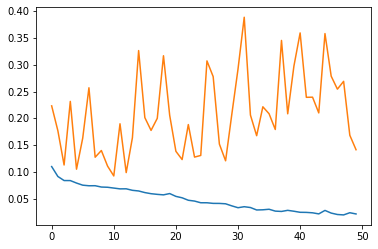

In [246]:
plt.plot(history.history["loss"])
plt.plot(history.history['val_loss'])
plt.show()

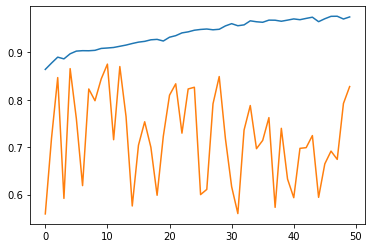

In [247]:
plt.plot(history.history["accuracy"])
plt.plot(history.history['val_accuracy'])
plt.show()

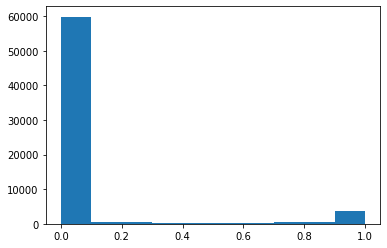

In [248]:
plt.hist(predict)
plt.show()

In [249]:
print(predict)

[[4.1722803e-23]
 [1.0595339e-26]
 [3.4932999e-30]
 ...
 [1.8130714e-26]
 [1.2790341e-15]
 [4.9549039e-19]]


In [250]:
make_csv(predict, S1_grid_id,'y_S1S2')

In [284]:
from osgeo import ogr

diff = []
diff.append(['id','diff'])
mach_res = ogr.Open('CLUSTERS/nairobi_grid100_clust_morpho_10pc_10cl.shp')
mach_layer = mach_res.GetLayer()
for mach_patch in mach_layer :
    probstab = mach_patch.GetField('probstab')
    mach_id = mach_patch.GetField('id')
    index = S1_grid_id.index(mach_id)
    if probstab != None :
        line = [int(mach_id),predict[index,0] - probstab]
        diff.append(line)
    else :
        line = [int(mach_id),None]
        diff.append(line)

In [285]:
import csv

name = 'machVSdeep'

with open(str(name)+'.csv','w') as file :
    write = csv.writer(file)
    write.writerows(diff)

In [286]:
print(diff)

[['id', 'diff'], [86, None], [87, None], [88, None], [89, None], [90, None], [91, None], [92, None], [93, None], [94, None], [95, 7.555273327615405e-18], [96, None], [97, 1.1951505713233722e-15], [98, 1.537971949836169e-17], [99, 7.379559618342726e-16], [100, None], [101, None], [102, 5.806130803160043e-16], [103, 3.860366696563667e-21], [104, 8.538711296355017e-25], [105, 2.1636174822196265e-23], [106, 3.2988729222761384e-22], [107, 6.73884708343557e-14], [108, 2.516198605061781e-21], [109, 1.99161827048041e-19], [110, 6.769167402354463e-19], [111, 8.512709554239275e-21], [112, 5.5808891651424115e-24], [113, 2.090659558256171e-16], [339, None], [340, None], [341, 1.8534983659826905e-19], [342, 2.4125042582377955e-29], [343, None], [344, None], [345, None], [346, None], [347, 9.283795430539902e-17], [348, 6.552952523195606e-18], [349, 4.293065359666296e-22], [350, None], [351, None], [352, None], [353, 1.252871747241754e-20], [354, 2.728274064864788e-16], [355, None], [356, 2.167688448